# Predicting and Explaining Medical Insurance Costs

## 1. Problem Framing

Medical insurance providers seek to understand the primary drivers of individual healthcare costs in order to improve pricing, risk assessment, and preventive strategies.

Objective:
- Predict individual medical insurance charges using demographic and lifestyle variables.
- Identify and interpret the most influential cost drivers while balancing predictive performance and interpretability.

Target Variable: charges (modeled primarily on the log scale).
Assumptions & Constraints:
- Cross-sectional data; results are associative, not causal.
- Costs are expected to be right-skewed.
- Dataset size favors interpretable models over highly complex ones.

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [39]:
pd.set_option('display.max_columns', None)

In [40]:
df = pd.read_csv('../data/medical-charges.csv')

In [41]:
df.shape

(1338, 7)

In [42]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 2. Data Audit & Quality Checks
The dataset was inspected for structural and data-quality issues prior to analysis.

Key checks performed:
- Verified data types and feature ranges
- Confirmed absence of missing values
- Identified and removed 1 duplicate record

After cleaning, the dataset was deemed suitable for exploratory analysis and modeling.

In [43]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [44]:
df.duplicated().sum()

1

In [45]:
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [46]:
df = df.drop_duplicates()

In [47]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


## 3. Hypothesis-Driven Exploratory Data Analysis (EDA)
EDA was conducted to test domain-informed hypotheses and guide modeling decisions rather than for purely descriptive purposes.

## 3.1 Distribution of Medical Charges
Medical charges exhibit a strong right skew with a long tail of high-cost individuals.
Implication:
- A log-transformation of the target variable is appropriate to stabilize variance and better satisfy linear model assumptions.

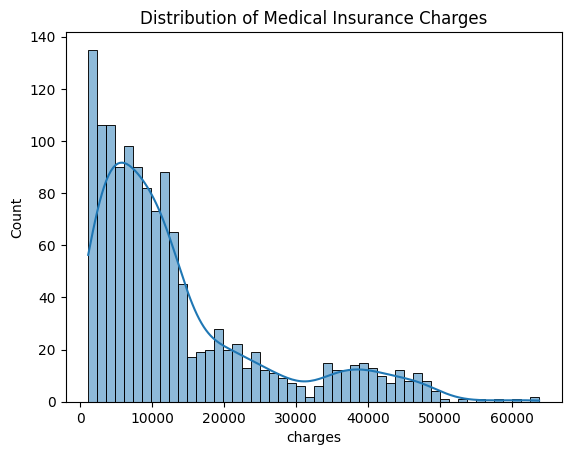

In [48]:
sns.histplot(df['charges'], bins=50, kde=True)
plt.title("Distribution of Medical Insurance Charges")
plt.show()

## 3.2 Smoking Status and Charges
Smoking status shows a pronounced separation in both median and variance of costs.
Insight:
- Smoking acts as a dominant additive cost driver, substantially increasing baseline insurance charges.

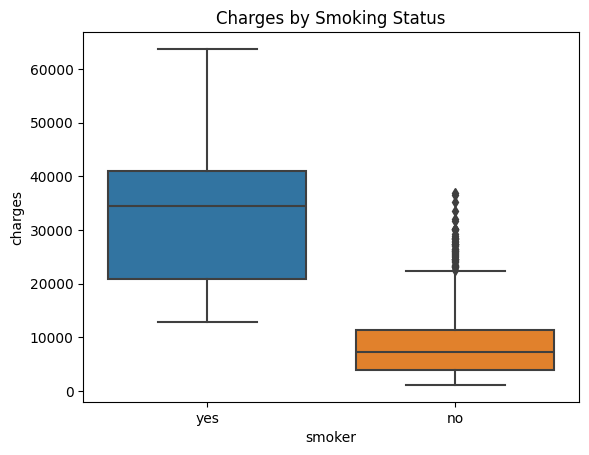

In [50]:
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Charges by Smoking Status')
plt.show()

## 3.3 Age and Charges
Charges increase with age for both smokers and non-smokers. The slopes appear largely parallel, with smokers consistently incurring higher baseline costs.


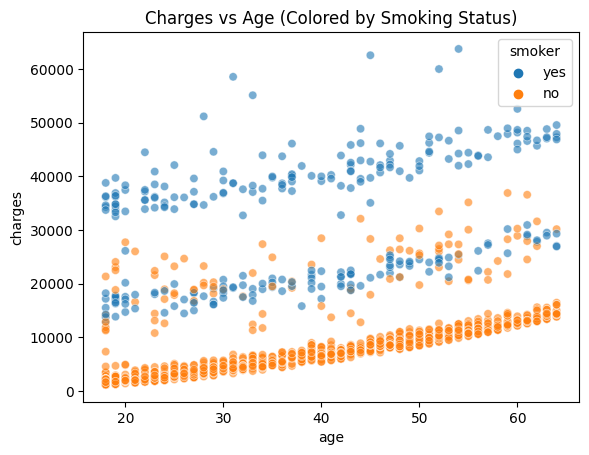

In [51]:
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, alpha=0.6)
plt.title('Charges vs Age (Colored by Smoking Status)')
plt.show()

## 3.4 BMI and Charges
BMI demonstrates minimal association with charges among non-smokers, but a clear positive relationship among smokers.

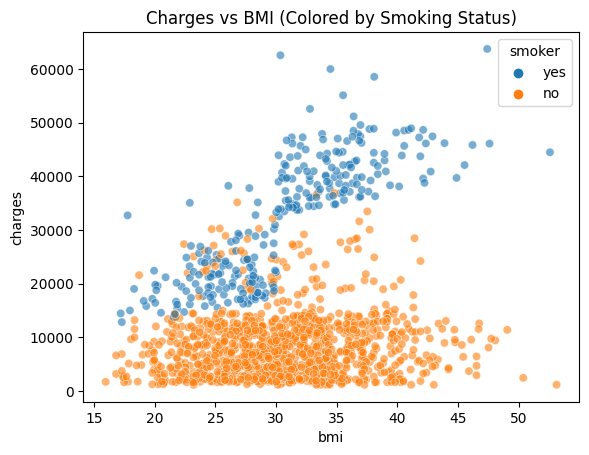

In [53]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.6)
plt.title('Charges vs BMI (Colored by Smoking Status)')
plt.show()

## 3.5 Other Variables (Sex, Region, Children)
- Sex and region show limited standalone predictive power.
- Number of children exhibits a modest positive association with costs.

These variables are retained for completeness and potential interaction effects.

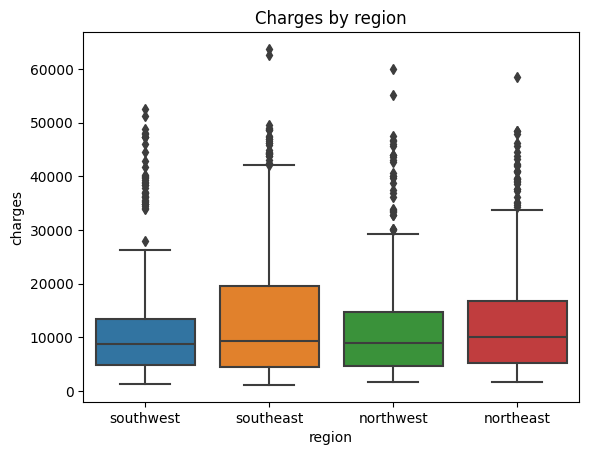

In [54]:
sns.boxplot(x='region', y='charges', data=df)
plt.title('Charges by region')
plt.show()

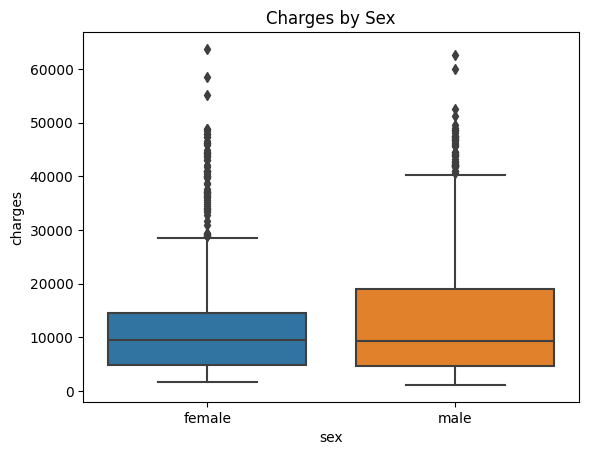

In [55]:
sns.boxplot(x='sex', y='charges', data=df)
plt.title('Charges by Sex')
plt.show()

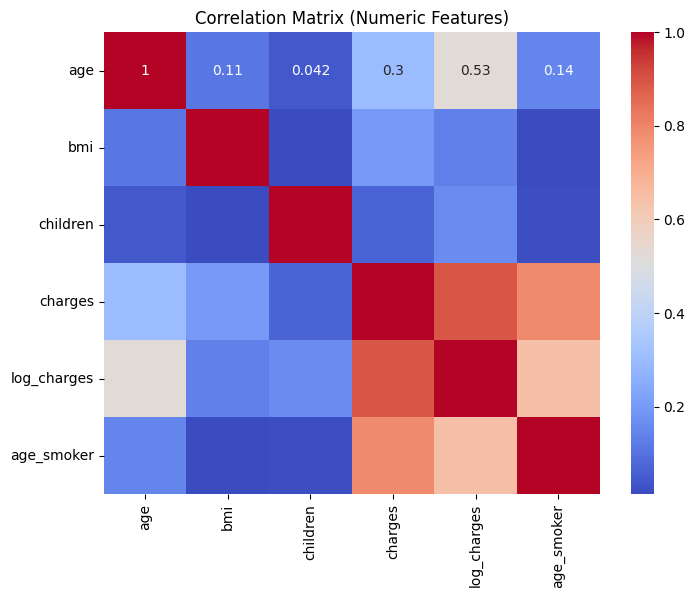

In [56]:
numeric_cols = df.select_dtypes(include=np.number)

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

## Feature Engineering
Based on EDA findings, the following transformations were applied:
- Log-transformation of the target variable (log(charges))
- Binary encoding of smoking status
- Interaction term between age and smoking status
- One-hot encoding of categorical variables (sex and region)

This approach embeds domain insights directly into the modeling process.

In [77]:
df['log_charges'] = np.log(df['charges'])
df['age_smoker'] = df['age'] * (df['smoker'] == 'yes').astype(int)

In [57]:
df_model = df.copy()

df_model['smoker_binary'] = (df_model['smoker'] == 'yes').astype(int)

df_model['bmi_smoker'] = df_model['bmi'] * df_model['smoker_binary']

df_model = df_model.drop(columns=['smoker'])

In [58]:
df_model = pd.get_dummies(
    df_model,
    columns=['sex', 'region'],
    drop_first = True
)

In [59]:
X = df_model.drop(columns=['charges', 'log_charges'])
y = df['log_charges']

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 5. Modeling Strategy
Multiple regression-based models were evaluated:
- Linear Regression (baseline)
- Ridge Regression
- Lasso Regression
- Random Forest Regressor

Models were compared using RMSE and R² on a held-out test set.

In [63]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [64]:
y_pred = lr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

rmse, r2

(0.3461501307740366, 0.8709087615960429)

In [65]:
coef_df = pd.DataFrame({
    'features': X_train.columns,
    'coefficient': lr.coef_
}).sort_values(by='coefficient', key=abs, ascending=False)

coef_df

,features,coefficient
4,smoker_binary,1.203804
9,region_southwest,-0.125252
8,region_southeast,-0.110737
2,children,0.109116
6,sex_male,-0.086317
5,bmi_smoker,0.053959
0,age,0.041291
7,region_northwest,-0.035607
3,age_smoker,-0.034024
1,bmi,0.000228


In [67]:
X = X.drop(columns=['age_smoker'])

In [68]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_ridge, r2_ridge

(0.34763755467497803, 0.8697969553493942)

In [69]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

rmse_lasso, r2_lasso


(0.37414086241882016, 0.8491872521302247)

In [70]:
pd.Series(lasso.coef_, index=X_train.columns)

age                 0.040061
bmi                -0.007032
children            0.102054
age_smoker         -0.026507
smoker_binary       0.000000
bmi_smoker          0.082606
sex_male           -0.053587
region_northwest    0.000000
region_southeast   -0.007871
region_southwest   -0.022018
dtype: float64

In [72]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

rmse_rf, r2_rf

(0.3779143771860977, 0.8461297725704103)

In [73]:
rf_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

rf_importance

age                 0.376226
bmi_smoker          0.335744
bmi                 0.091223
smoker_binary       0.059342
children            0.052687
age_smoker          0.047682
sex_male            0.012578
region_northwest    0.009001
region_southeast    0.008879
region_southwest    0.006638
dtype: float64

## Model Evaluation & Comparison
Performance Summary (log-scale):
- Linear Regression: R² ≈ 0.87 (best)
- Ridge Regression: Comparable to linear regression
- Lasso Regression: Slightly worse due to coefficient instability under multicollinearity
- Random Forest: Lower performance, likely due to small dataset size and largely additive relationships

Conclusion: A simple linear regression model with domain-informed feature engineering outperformed more complex alternatives.

## Final Model Interpretation
Key findings from the final linear model:
- Smoking increases expected medical costs by over 200%, holding other factors constant
- Age significantly increases costs 
- Regional and gender effects are minimal

These results are consistent across EDA, linear coefficients, and tree-based feature importance rankings.

## 6. Residual Diagnostics
Residual analysis revealed:
- No strong heteroscedasticity patterns
- Approximately symmetric residual distribution

This suggests the model is well-specified for the given dat

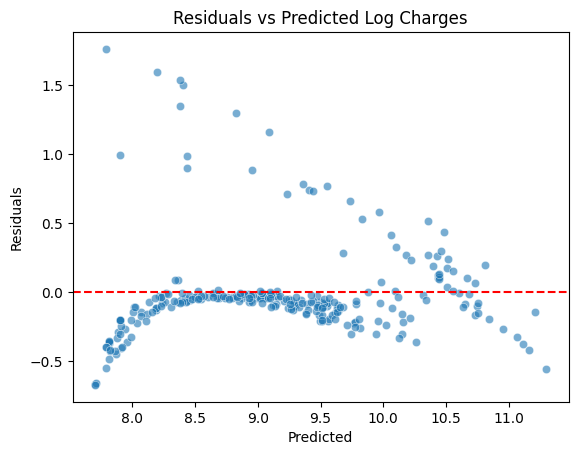

In [74]:
residuals = y_test - y_pred

sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted Log Charges")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

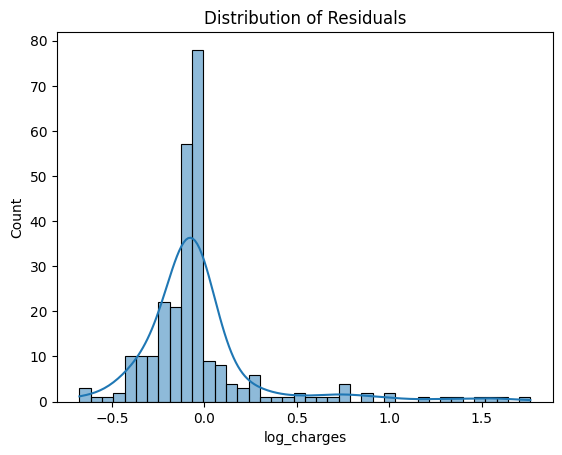

In [75]:
sns.histplot(residuals, bins=40, kde=True)
plt.title("Distribution of Residuals")
plt.show()

## Limitations & Future Work
- Incorporation of longitudinal or clinical variables could improve predictive power
- Causal inference techniques could further clarify risk factors
- Gradient boosting models could be explored with larger datasets

## Conclusion
This project demonstrates that thoughtful EDA and domain-driven feature engineering can enable interpretable linear models to outperform more complex algorithms on structured healthcare data, making them well-suited for real-world decision-making.